# 🎯 Analyse de Sentiment - E-commerce Olist

## Objectif
Prédire le sentiment des clients (négatif / neutre / positif) à partir des reviews textuelles et agréger les résultats par boutique (seller_id).

## Méthodologie
1. Chargement et fusion des données
2. Création des labels de sentiment
3. Préprocessing NLP (lemmatisation, stopwords portugais)
4. Vectorisation TF-IDF
5. Modélisation (Logistic Regression avec validation croisée)
6. Évaluation et agrégation par seller

In [3]:
import pandas as pd
import numpy as np

## 1. 📦 Imports et configuration

In [4]:
reviews = pd.read_csv("../Data/olist_order_reviews_dataset.csv")
items   = pd.read_csv("../Data/olist_order_items_dataset.csv")
sellers = pd.read_csv("../Data/olist_sellers_dataset.csv")

## 2. 📂 Chargement des données

In [5]:
# Sélection des colonnes pertinentes pour l'analyse de sentiment
reviews_clean = reviews[[
    "order_id",
    "review_score",
    "review_comment_message"
]].copy()

items_clean = items[[
    "order_id",
    "seller_id",
    "product_id"
]].copy()

sellers_clean = sellers[[
    "seller_id",
    "seller_city",
    "seller_state"
]].copy()

## 3. 🧹 Nettoyage des reviews

Suppression des commentaires vides ou trop courts (< 5 caractères)

In [6]:
# Filtrer les reviews avec texte valide
reviews_clean = reviews_clean.dropna(subset=["review_comment_message"])
reviews_clean = reviews_clean[reviews_clean["review_comment_message"].str.len() > 5]

print(f"Reviews avec texte valide : {len(reviews_clean):,}")

Reviews avec texte valide : 39,623


### Vérification des doublons

⚠️ **Important** : Un order_id peut avoir plusieurs reviews si le client a modifié son commentaire. On garde la dernière review par order_id.

In [7]:
duplicates_count = reviews_clean.duplicated(subset=["order_id"]).sum()
print(f"Nombre de doublons détectés : {duplicates_count}")

# Garder la dernière review par order_id (en cas de modification par le client)
reviews_clean = reviews_clean.drop_duplicates(subset=["order_id"], keep="last")
print(f"Reviews après dédoublonnage : {len(reviews_clean):,}")

Nombre de doublons détectés : 135
Reviews après dédoublonnage : 39,488


## 4. 🔗 Fusion des datasets

**Note** : Un order peut contenir plusieurs produits de différents sellers. Nous gardons une ligne par (order, seller) pour l'analyse par boutique.

In [8]:
# Fusion reviews + items (pour avoir seller_id)
reviews_items = pd.merge(
    reviews_clean,
    items_clean,
    on="order_id",
    how="inner"
)

print(f"Après fusion reviews-items : {len(reviews_items):,} lignes")

Après fusion reviews-items : 45,960 lignes


In [9]:
reviews_items.head()

,order_id,review_score,review_comment_message,seller_id,product_id
0,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,a1043bafd471dff536d0c462352beb48,52c80cedd4e90108bf4fa6a206ef6b03
1,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,989becdce12ebc39863c2bceab6f3ca1,3880d25d502b15b1de6fddc42ad1d67a
2,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,05ff92fedb5be47920fea08e501238b9,61a4100ccd6d9c4c808a1fd954ddb8ad
3,9d6f15f95d01e79bd1349cc208361f09,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",db4350fd57ae30082dec7acbaacc17f9,acffe5d7cd56e6b564cf6841486644ff
4,e51478e7e277a83743b6f9991dbfa3fb,5,"Vendedor confiável, produto ok e entrega antes...",974cf2cb8f4b7add98709c30df02fe10,6871a3c157d6f51697e887f3c3598479


In [10]:
# Fusion avec sellers (optionnel pour contexte géographique)
df_base = pd.merge(
    reviews_items,
    sellers_clean,
    on="seller_id",
    how="left"
)

print(f"Dataset final : {len(df_base):,} lignes")

Dataset final : 45,960 lignes


In [11]:
df_base.head()

,order_id,review_score,review_comment_message,seller_id,product_id,seller_city,seller_state
0,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,a1043bafd471dff536d0c462352beb48,52c80cedd4e90108bf4fa6a206ef6b03,ilicinea,MG
1,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,989becdce12ebc39863c2bceab6f3ca1,3880d25d502b15b1de6fddc42ad1d67a,curitiba,PR
2,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,05ff92fedb5be47920fea08e501238b9,61a4100ccd6d9c4c808a1fd954ddb8ad,santo angelo,RS
3,9d6f15f95d01e79bd1349cc208361f09,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",db4350fd57ae30082dec7acbaacc17f9,acffe5d7cd56e6b564cf6841486644ff,sao paulo,SP
4,e51478e7e277a83743b6f9991dbfa3fb,5,"Vendedor confiável, produto ok e entrega antes...",974cf2cb8f4b7add98709c30df02fe10,6871a3c157d6f51697e887f3c3598479,araraquara,SP


### Sauvegarde du dataset fusionné

In [12]:
df_base.to_csv("reviews_items_sellers_base.csv", index=False)
print("✅ Dataset sauvegardé")

✅ Dataset sauvegardé


## 5. 🏷️ Création des labels de sentiment

Mapping basé sur `review_score` :
- **Négatif** : scores 1-2
- **Neutre** : score 3
- **Positif** : scores 4-5

In [13]:
df = df_base.copy()

def map_sentiment(score):
    """Convertit un score (1-5) en label de sentiment"""
    if score in [1, 2]:
        return "negative"
    elif score == 3:
        return "neutral"
    else:  # 4, 5
        return "positive"

df["sentiment_label"] = df["review_score"].apply(map_sentiment)

In [14]:
# Distribution des classes
print("Distribution des sentiments :")
print(df["sentiment_label"].value_counts())
print("\nPourcentages :")
print(df["sentiment_label"].value_counts(normalize=True) * 100)

Distribution des sentiments :
sentiment_label
positive    28079
negative    13740
neutral      4141
Name: count, dtype: int64

Pourcentages :
sentiment_label
positive    61.094430
negative    29.895561
neutral      9.010009
Name: proportion, dtype: float64


C:\Users\Reda\AppData\Local\Temp\ipykernel_18476\2240585827.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="sentiment_label", palette="viridis")


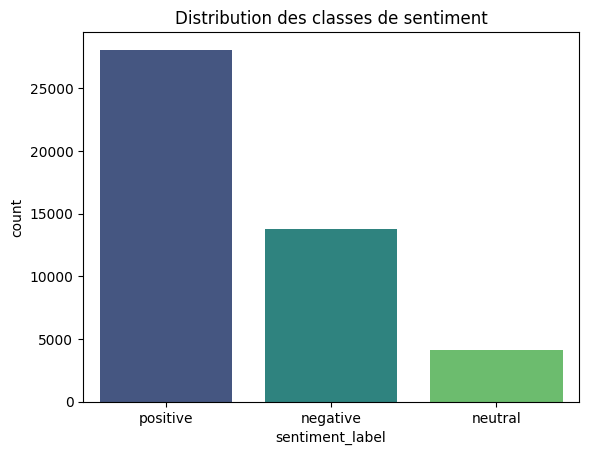

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x="sentiment_label", palette="viridis")
plt.title("Distribution des classes de sentiment")
plt.show()

C:\Users\Reda\AppData\Local\Temp\ipykernel_18476\3769398902.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="review_score", palette="mako")


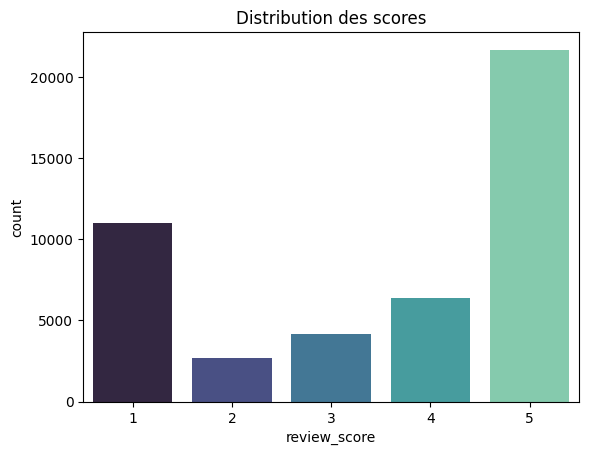

In [16]:
sns.countplot(data=df, x="review_score", palette="mako")
plt.title("Distribution des scores")
plt.show()

## 6. 🔤 Préprocessing NLP

Installation des dépendances pour le traitement du portugais

In [17]:
# Installation de NLTK seulement (spaCy n'est pas nécessaire pour cette approche)
# %pip install nltk

c:\Users\Reda\Documents\ANALYTICS\.venv\Lib\site-packages\confection\__init__.py:38: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1 import BaseModel, Extra, ValidationError, create_model
Traceback (most recent call last):
  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 148, in _get_module_details
  File "<frozen runpy>", line 112, in _get_module_details
  File "c:\Users\Reda\Documents\ANALYTICS\.venv\Lib\site-packages\spacy\__init__.py", line 13, in <module>
    from . import pipeline  # noqa: F401
    ^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Reda\Documents\ANALYTICS\.venv\Lib\site-packages\spacy\pipeline\__init__.py", line 1, in <module>
    from .attributeruler import AttributeRuler
  File "c:\Users\Reda\Documents\ANALYTICS\.venv\Lib\site-packages\spacy\pipeline\attributeruler.py", line 10, in <module>
    from ..language import Language
  File "c:\Users\Reda\Documents\ANALYTICS\.venv

In [18]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stopwords_pt = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Reda\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [20]:
import re
from nltk.corpus import stopwords

# Récupérer les stopwords portugais
stopwords_pt = set(stopwords.words('portuguese'))

def preprocess_text(text):
    """
    Préprocessing NLP optimisé pour l'analyse de sentiment.
    Version simplifiée sans spaCy pour éviter les problèmes de compatibilité.
    
    Étapes :
    1. Minuscules
    2. Nettoyage (conservation des lettres accentuées + espaces)
    3. Suppression des stopwords
    4. Filtrage : tokens courts, espaces
    
    Arguments:
        text (str): Texte brut de la review
    
    Returns:
        str: Texte nettoyé
    """
    if pd.isna(text):
        return ""
    
    # Minuscules
    text = text.lower()
    
    # Nettoyage : on garde lettres (avec accents), chiffres, espaces
    # On supprime les caractères spéciaux/emoji mais garde !? qui sont importants pour le sentiment
    text = re.sub(r'[^a-záàâãéèêíïóôõöúçñ0-9\s!?]', ' ', text)
    
    # Réduction des espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenisation simple et filtrage
    tokens = []
    for word in text.split():
        # Supprimer stopwords, ponctuation pure, et mots très courts
        if (word not in stopwords_pt 
            and word not in ['!', '?', '.', ',', '...']
            and len(word) >= 2):
            tokens.append(word)
    
    return " ".join(tokens)

In [21]:
# Application du preprocessing sur toutes les reviews (avec barre de progression)
from tqdm import tqdm
tqdm.pandas()

print("🔄 Préprocessing en cours...")
df["review_processed"] = df["review_comment_message"].progress_apply(preprocess_text)

# Vérification : affichage de quelques exemples
print("\n📝 Exemples de preprocessing :")
df[["review_comment_message", "review_processed"]].head(10)

🔄 Préprocessing en cours...


100%|██████████| 45960/45960 [00:00<00:00, 122527.75it/s]


📝 Exemples de preprocessing :


,review_comment_message,review_processed
0,Recebi bem antes do prazo estipulado.,recebi bem antes prazo estipulado
1,Parabéns lojas lannister adorei comprar pela I...,parabéns lojas lannister adorei comprar intern...
2,aparelho eficiente. no site a marca do aparelh...,aparelho eficiente site marca aparelho impress...
3,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",pouco travando valor ta boa
4,"Vendedor confiável, produto ok e entrega antes...",vendedor confiável produto ok entrega antes prazo
5,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",gostaria saber sempre recebi compra agora decp...
6,Péssimo,péssimo
7,Loja nota 10,loja nota 10
8,obrigado pela atençao amim dispensada,obrigado atençao amim dispensada
9,A compra foi realizada facilmente.\r\nA entreg...,compra realizada facilmente entrega efetuada a...


## 7. 🤖 Modélisation : Pipeline TF-IDF + Logistic Regression

### 7.1 Préparation des données (train/test split)

In [22]:
from sklearn.model_selection import train_test_split

# Features (X) : texte préprocessé
X = df["review_processed"]


# Target (y) : labels de sentiment
y = df["sentiment_label"]

# Split avec stratification pour garder les proportions de classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Train set : {len(X_train):,} samples")
print(f"Test set : {len(X_test):,} samples")
print("\nDistribution dans le train :")
print(y_train.value_counts(normalize=True))

Train set : 36,768 samples
Test set : 9,192 samples

Distribution dans le train :
sentiment_label
positive    0.610939
negative    0.298956
neutral     0.090106
Name: proportion, dtype: float64


In [23]:
### 7.2 Construction du pipeline de classification

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Pipeline : TF-IDF + Logistic Regression avec gestion du déséquilibre
sentiment_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,      # Réduction pour éviter l'overfitting
        ngram_range=(1, 2),      # Unigrams + bigrams
        min_df=5,                # Ignore les mots très rares (< 5 occurrences)
        max_df=0.8,              # Ignore les mots trop fréquents (> 80%)
        sublinear_tf=True        # Utilise log(tf) au lieu de tf
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",  # Compense le déséquilibre des classes
        random_state=42,
        solver='saga',            # Solver adapté aux datasets larges
        n_jobs=-1
    ))
])

print("✅ Pipeline configuré")

✅ Pipeline configuré


### 7.3 Entraînement du modèle

In [25]:
%%time
# Entraînement du pipeline
sentiment_pipeline.fit(X_train, y_train)

print("✅ Modèle entraîné avec succès")

c:\Users\Reda\Documents\ANALYTICS\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


✅ Modèle entraîné avec succès
CPU times: total: 25.6 s
Wall time: 25.7 s


c:\Users\Reda\Documents\ANALYTICS\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [26]:
### 7.4 Évaluation sur le test set

In [27]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Prédictions sur le test set
y_pred = sentiment_pipeline.predict(X_test)

# Métriques globales
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"🎯 Accuracy : {accuracy:.4f}")
print(f"📊 F1-score (macro) : {f1_macro:.4f}")
print(f"📊 F1-score (weighted) : {f1_weighted:.4f}")
print("\n" + "="*60)
print("📋 Rapport de classification détaillé :")
print("="*60)
print(classification_report(y_test, y_pred, digits=4))

🎯 Accuracy : 0.7878
📊 F1-score (macro) : 0.6731
📊 F1-score (weighted) : 0.8070

📋 Rapport de classification détaillé :
              precision    recall  f1-score   support

    negative     0.7873    0.7838    0.7856      2748
     neutral     0.2713    0.4879    0.3487       828
    positive     0.9428    0.8339    0.8850      5616

    accuracy                         0.7878      9192
   macro avg     0.6671    0.7019    0.6731      9192
weighted avg     0.8358    0.7878    0.8070      9192



### 7.5 Validation croisée stratifiée (robustesse)

In [28]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Configuration de la validation croisée
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("🔄 Validation croisée (5 folds) en cours...")

# Évaluation avec accuracy
cv_accuracy = cross_val_score(
    sentiment_pipeline, X_train, y_train, 
    cv=skf, 
    scoring='accuracy',
    n_jobs=-1
)

# Évaluation avec F1-macro (plus robuste au déséquilibre)
cv_f1_macro = cross_val_score(
    sentiment_pipeline, X_train, y_train, 
    cv=skf, 
    scoring='f1_macro',
    n_jobs=-1
)

print("\n" + "="*60)
print("📊 Résultats de la validation croisée")
print("="*60)
print(f"Accuracy par fold : {cv_accuracy}")
print(f"  → Moyenne : {cv_accuracy.mean():.4f} (+/- {cv_accuracy.std() * 2:.4f})")
print()
print(f"F1-macro par fold : {cv_f1_macro}")
print(f"  → Moyenne : {cv_f1_macro.mean():.4f} (+/- {cv_f1_macro.std() * 2:.4f})")
print("="*60)

🔄 Validation croisée (5 folds) en cours...

📊 Résultats de la validation croisée
Accuracy par fold : [0.78583084 0.70655426 0.79983682 0.79219366 0.77192982]
  → Moyenne : 0.7713 (+/- 0.0673)

F1-macro par fold : [0.67912781 0.61781542 0.67247275 0.66336843 0.66040793]
  → Moyenne : 0.6586 (+/- 0.0429)


### 7.6 Matrice de confusion

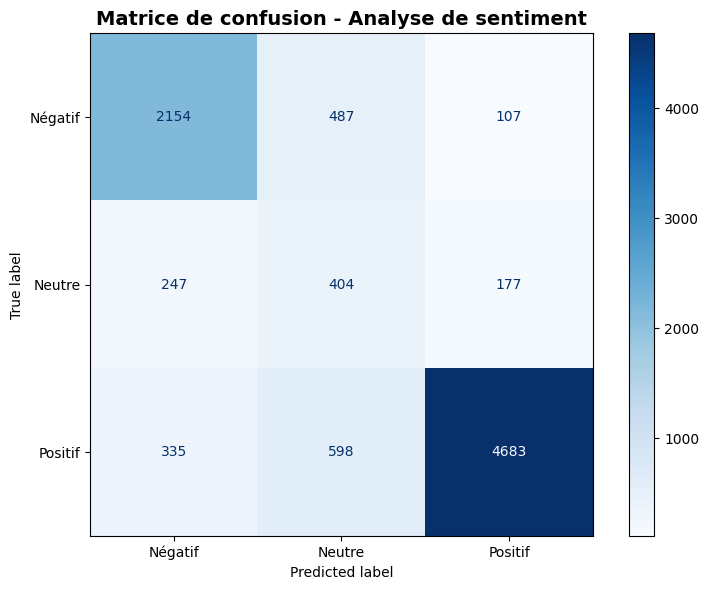


📊 Analyse des erreurs par classe :
  Negative : 78.38% bien classés (2154/2748)
  Neutral : 48.79% bien classés (404/828)
  Positive : 83.39% bien classés (4683/5616)


In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=["negative", "neutral", "positive"])

# Visualisation
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=["Négatif", "Neutre", "Positif"]
)
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title("Matrice de confusion - Analyse de sentiment", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Calcul des taux d'erreur par classe
print("\n📊 Analyse des erreurs par classe :")
for i, label in enumerate(["negative", "neutral", "positive"]):
    total = cm[i].sum()
    correct = cm[i, i]
    accuracy_class = correct / total * 100
    print(f"  {label.capitalize()} : {accuracy_class:.2f}% bien classés ({correct}/{total})")

In [30]:
%%time
# Entraînement sur l'ensemble complet des données
sentiment_pipeline_final = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1, 2),
        min_df=5,
        max_df=0.8,
        sublinear_tf=True
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=42,
        solver='saga',
        n_jobs=-1
    ))
])

sentiment_pipeline_final.fit(df["review_processed"], df["sentiment_label"])
print("✅ Modèle final entraîné sur toutes les données")

c:\Users\Reda\Documents\ANALYTICS\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


✅ Modèle final entraîné sur toutes les données
CPU times: total: 42.2 s
Wall time: 42.5 s


c:\Users\Reda\Documents\ANALYTICS\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [31]:
# Prédiction sur toutes les reviews
df["sentiment_pred"] = sentiment_pipeline_final.predict(df["review_processed"])

print("Distribution des sentiments prédits :")
print(df["sentiment_pred"].value_counts())
print("\nPourcentages :")
print(df["sentiment_pred"].value_counts(normalize=True) * 100)

Distribution des sentiments prédits :
sentiment_pred
positive    28097
negative    14687
neutral      3176
Name: count, dtype: int64

Pourcentages :
sentiment_pred
positive    61.133594
negative    31.956049
neutral      6.910357
Name: proportion, dtype: float64


In [32]:
## 9. 📊 Agrégation des sentiments par boutique (seller_id)

In [33]:
# Agrégation des métriques de sentiment par seller
seller_sentiment = (
    df.groupby("seller_id")
      .agg(
          n_reviews=("sentiment_pred", "size"),
          mean_review_score=("review_score", "mean"),
          pct_negative=("sentiment_pred", lambda x: (x == "negative").mean() * 100),
          pct_neutral=("sentiment_pred", lambda x: (x == "neutral").mean() * 100),
          pct_positive=("sentiment_pred", lambda x: (x == "positive").mean() * 100)
      )
      .reset_index()
)

# Création d'un indice de sentiment : positif - négatif
seller_sentiment["sentiment_index"] = (
    seller_sentiment["pct_positive"] - seller_sentiment["pct_negative"]
)

print(f"Nombre de boutiques analysées : {len(seller_sentiment):,}")
seller_sentiment.head(10)

Nombre de boutiques analysées : 2,535


,seller_id,n_reviews,mean_review_score,pct_negative,pct_neutral,pct_positive,sentiment_index
0,0015a82c2db000af6aaaf3ae2ecb0532,1,1.000000,0.000000,100.000000,0.000000,0.000000
1,001cca7ae9ae17fb1caed9dfb1094831,113,3.504425,30.088496,8.849558,61.061947,30.973451
2,001e6ad469a905060d959994f1b41e4f,1,1.000000,100.000000,0.000000,0.000000,-100.000000
3,002100f778ceb8431b7a1020ff7ab48f,17,3.411765,35.294118,11.764706,52.941176,17.647059
4,004c9cd9d87a3c30c522c48c4fc07416,63,3.682540,19.047619,9.523810,71.428571,52.380952
5,00720abe85ba0859807595bbf045a33b,13,2.846154,30.769231,46.153846,23.076923,-7.692308
6,00d8b143d12632bad99c0ad66ad52825,1,5.000000,0.000000,0.000000,100.000000,100.000000
7,00ee68308b45bc5e2660cd833c3f81cc,61,3.918033,27.868852,4.918033,67.213115,39.344262
8,00fc707aaaad2d31347cf883cd2dfe10,67,2.835821,50.746269,13.432836,35.820896,-14.925373
9,010da0602d7774602cd1b3f5fb7b709e,5,1.000000,100.000000,0.000000,0.000000,-100.000000


In [34]:
### Filtrage : boutiques avec au moins 20 reviews

In [35]:
# Filtre sur les sellers avec suffisamment de reviews pour être statistiquement robuste
seller_sentiment_filtered = seller_sentiment[seller_sentiment["n_reviews"] >= 20]

print(f"Boutiques avec ≥ 20 reviews : {len(seller_sentiment_filtered):,}")

# Top 10 meilleures boutiques (sentiment le plus positif)
print("\n🏆 Top 10 boutiques - Meilleur sentiment :")
print(seller_sentiment_filtered.nlargest(10, "sentiment_index")[
    ["seller_id", "n_reviews", "mean_review_score", "pct_positive", "pct_negative", "sentiment_index"]
])

# Top 10 pires boutiques (sentiment le plus négatif)
print("\n⚠️ Top 10 boutiques - Pire sentiment :")
print(seller_sentiment_filtered.nsmallest(10, "sentiment_index")[
    ["seller_id", "n_reviews", "mean_review_score", "pct_positive", "pct_negative", "sentiment_index"]
])

Boutiques avec ≥ 20 reviews : 465

🏆 Top 10 boutiques - Meilleur sentiment :
                             seller_id  n_reviews  mean_review_score  \
708   48efc9d94a9834137efd9ea76b065a38         27           5.000000   
1701  ac3508719a1d8f5b7614b798f70af136         46           4.673913   
1331  83e197e95a1bbabc8c75e883ed016c47         21           4.809524   
537   376a891762bbdecbc02b4b6adec3fdda         20           4.800000   
1384  8a130737016f838139d31878787a39c9         27           4.629630   
1169  744dac408745240a2c2528fb1b6028f3         40           4.600000   
1650  a5cba26a62b8b4d0145b68b841e62e7f         32           4.531250   
1992  c864036feaab8c1659f65ea4faebe1da         24           4.625000   
449   2dee2ce60de9709b1a24083217181a1f         23           4.652174   
1569  9d4db00d65d7760644ac0c14edb5fd86         34           4.470588   

      pct_positive  pct_negative  sentiment_index  
708     100.000000      0.000000       100.000000  
1701     95.652174      2.

In [36]:
### 10.1 Distribution globale des sentiments prédits

C:\Users\Reda\AppData\Local\Temp\ipykernel_18476\2848654257.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values,


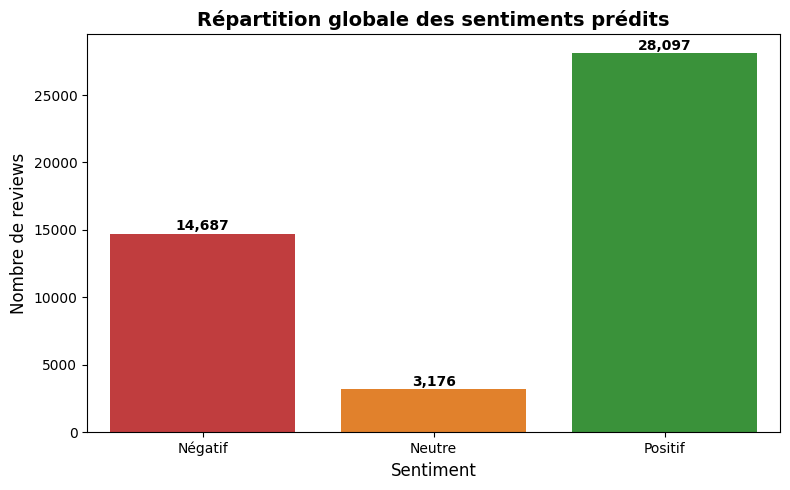

In [37]:
plt.figure(figsize=(8, 5))
sentiment_counts = df["sentiment_pred"].value_counts()
colors = ['#d62728', '#ff7f0e', '#2ca02c']  # Rouge, Orange, Vert
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, 
            order=["negative", "neutral", "positive"], palette=colors)
plt.title("Répartition globale des sentiments prédits", fontsize=14, fontweight='bold')
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Nombre de reviews", fontsize=12)
plt.xticks([0, 1, 2], ['Négatif', 'Neutre', 'Positif'])
for i, v in enumerate(sentiment_counts[["negative", "neutral", "positive"]].values):
    plt.text(i, v + 50, f'{v:,}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

In [38]:
### 10.2 Distribution du nombre de reviews par boutique

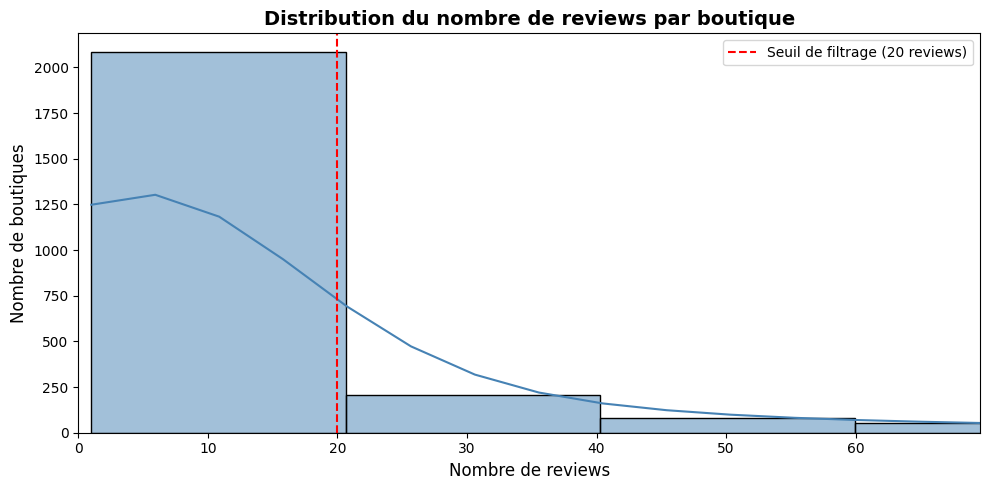

In [39]:
plt.figure(figsize=(10, 5))
sns.histplot(seller_sentiment["n_reviews"], bins=50, kde=True, color='steelblue')
plt.title("Distribution du nombre de reviews par boutique", fontsize=14, fontweight='bold')
plt.xlabel("Nombre de reviews", fontsize=12)
plt.ylabel("Nombre de boutiques", fontsize=12)
plt.xlim(0, seller_sentiment["n_reviews"].quantile(0.95))
plt.axvline(20, color='red', linestyle='--', label='Seuil de filtrage (20 reviews)')
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
### 10.3 Top 10 boutiques - Meilleur sentiment

C:\Users\Reda\AppData\Local\Temp\ipykernel_18476\2756195032.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Reda\AppData\Local\Temp\ipykernel_18476\2756195032.py:13: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Reda\Documents\ANALYTICS\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


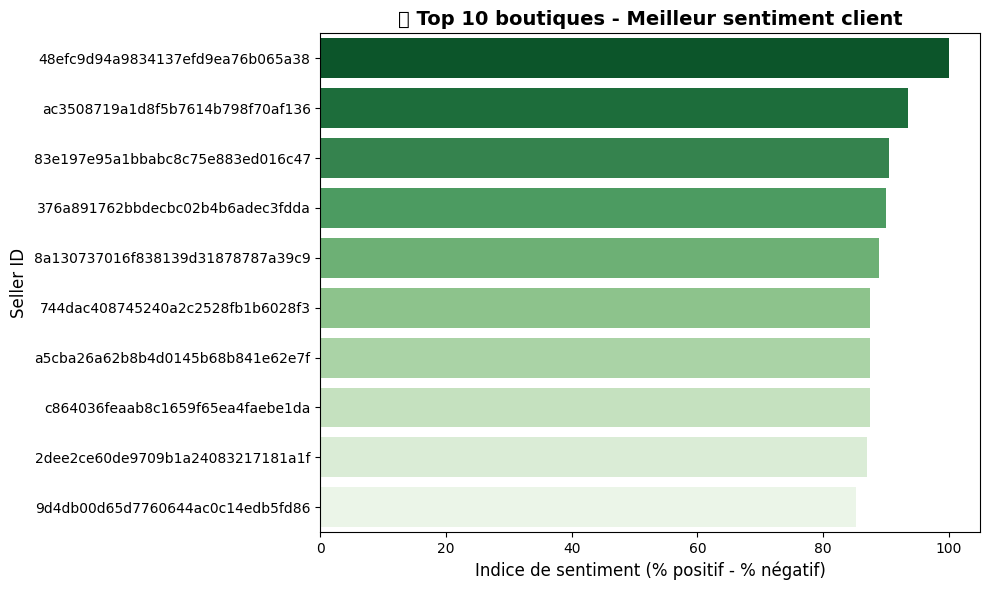

In [41]:
top10_best = seller_sentiment_filtered.nlargest(10, "sentiment_index")

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10_best,
    y='seller_id',
    x='sentiment_index',
    palette='Greens_r'
)
plt.title("🏆 Top 10 boutiques - Meilleur sentiment client", fontsize=14, fontweight='bold')
plt.xlabel("Indice de sentiment (% positif - % négatif)", fontsize=12)
plt.ylabel("Seller ID", fontsize=12)
plt.tight_layout()
plt.show()

In [42]:
### 10.4 Top 10 boutiques - Pire sentiment

C:\Users\Reda\AppData\Local\Temp\ipykernel_18476\1997849029.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


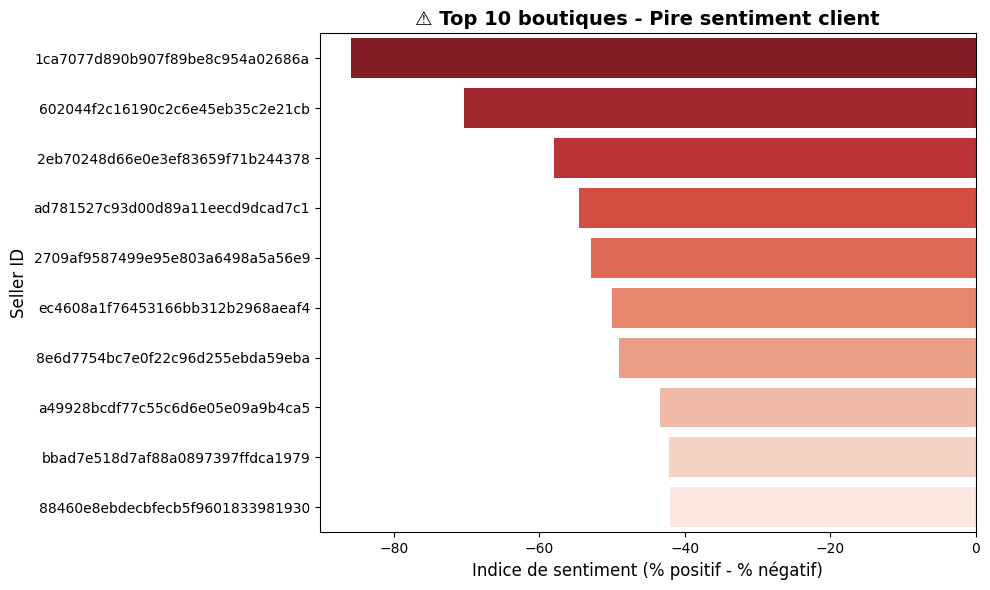

In [43]:
top10_worst = seller_sentiment_filtered.nsmallest(10, "sentiment_index")

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10_worst,
    y='seller_id',
    x='sentiment_index',
    palette='Reds_r'
)
plt.title("⚠️ Top 10 boutiques - Pire sentiment client", fontsize=14, fontweight='bold')
plt.xlabel("Indice de sentiment (% positif - % négatif)", fontsize=12)
plt.ylabel("Seller ID", fontsize=12)
plt.tight_layout()
plt.show()

In [44]:
### 10.5 Corrélation : Note moyenne vs Indice de sentiment

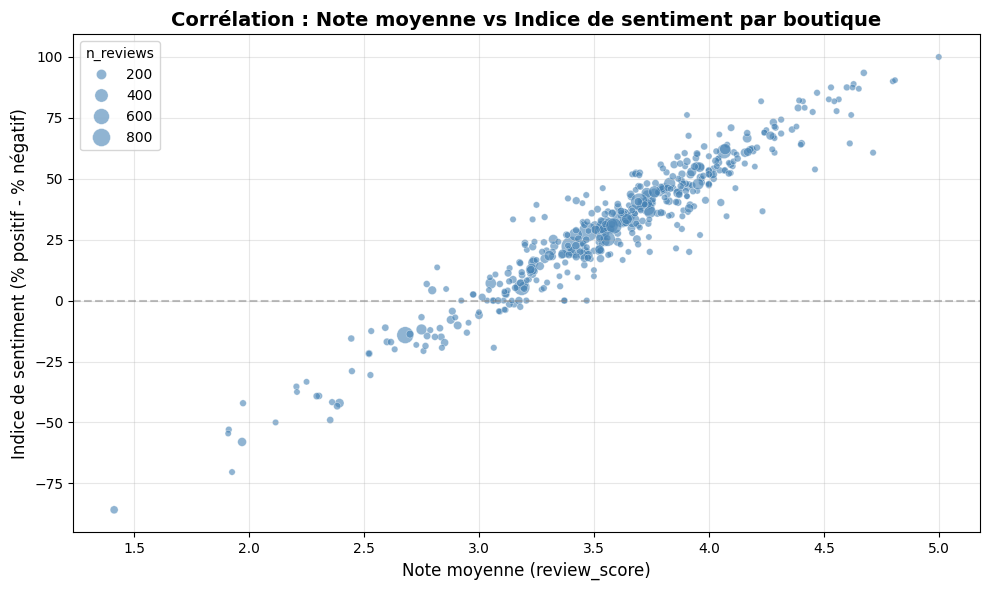


📊 Corrélation (Pearson) : 0.9579


In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=seller_sentiment_filtered,
    x="mean_review_score",
    y="sentiment_index",
    size="n_reviews",
    sizes=(20, 200),
    alpha=0.6,
    color='steelblue'
)
plt.title("Corrélation : Note moyenne vs Indice de sentiment par boutique", 
          fontsize=14, fontweight='bold')
plt.xlabel("Note moyenne (review_score)", fontsize=12)
plt.ylabel("Indice de sentiment (% positif - % négatif)", fontsize=12)
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calcul de la corrélation
correlation = seller_sentiment_filtered["mean_review_score"].corr(
    seller_sentiment_filtered["sentiment_index"]
)
print(f"\n📊 Corrélation (Pearson) : {correlation:.4f}")

## 11. 💾 Export des résultats

In [46]:
# Export des sentiments par seller
seller_sentiment.to_csv("seller_sentiment_analysis.csv", index=False)
print("✅ Résultats sauvegardés : seller_sentiment_analysis.csv")

# Export du dataset complet avec prédictions
df[["order_id", "seller_id", "review_score", "sentiment_label", "sentiment_pred", 
    "review_comment_message", "review_processed"]].to_csv(
    "reviews_with_sentiment.csv", index=False
)
print("✅ Dataset complet sauvegardé : reviews_with_sentiment.csv")

✅ Résultats sauvegardés : seller_sentiment_analysis.csv
✅ Dataset complet sauvegardé : reviews_with_sentiment.csv


### Export des graphiques

In [47]:
import os

# Créer le dossier pour les graphiques
os.makedirs("graphiques_sentiment", exist_ok=True)

print("📊 Export des graphiques en cours...\n")

# ========================================
# 1. Distribution des sentiments (labels de référence)
# ========================================
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="sentiment_label", order=["negative", "neutral", "positive"], 
              palette=['#d62728', '#ff7f0e', '#2ca02c'])
plt.title("Distribution des classes de sentiment (labels de référence)", fontsize=14, fontweight='bold')
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Nombre de reviews", fontsize=12)
plt.xticks([0, 1, 2], ['Négatif', 'Neutre', 'Positif'])
plt.tight_layout()
plt.savefig("graphiques_sentiment/01_distribution_labels.png", dpi=300, bbox_inches='tight')
plt.close()
print("✅ 1. Distribution des labels (référence)")

# ========================================
# 2. Distribution des scores (1-5)
# ========================================
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="review_score", palette="mako")
plt.title("Distribution des scores clients (1-5)", fontsize=14, fontweight='bold')
plt.xlabel("Score", fontsize=12)
plt.ylabel("Nombre de reviews", fontsize=12)
plt.tight_layout()
plt.savefig("graphiques_sentiment/02_distribution_scores.png", dpi=300, bbox_inches='tight')
plt.close()
print("✅ 2. Distribution des scores")

# ========================================
# 3. Matrice de confusion
# ========================================
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=["Négatif", "Neutre", "Positif"]
)
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title("Matrice de confusion - Analyse de sentiment", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("graphiques_sentiment/03_matrice_confusion.png", dpi=300, bbox_inches='tight')
plt.close()
print("✅ 3. Matrice de confusion")

# ========================================
# 4. Distribution des sentiments prédits
# ========================================
plt.figure(figsize=(8, 5))
sentiment_counts = df["sentiment_pred"].value_counts()
colors = ['#d62728', '#ff7f0e', '#2ca02c']
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, 
            order=["negative", "neutral", "positive"], palette=colors)
plt.title("Répartition globale des sentiments prédits", fontsize=14, fontweight='bold')
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Nombre de reviews", fontsize=12)
plt.xticks([0, 1, 2], ['Négatif', 'Neutre', 'Positif'])
for i, v in enumerate(sentiment_counts[["negative", "neutral", "positive"]].values):
    plt.text(i, v + 50, f'{v:,}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.savefig("graphiques_sentiment/04_distribution_predictions.png", dpi=300, bbox_inches='tight')
plt.close()
print("✅ 4. Distribution des prédictions")

# ========================================
# 5. Distribution du nombre de reviews par boutique
# ========================================
plt.figure(figsize=(10, 5))
sns.histplot(seller_sentiment["n_reviews"], bins=50, kde=True, color='steelblue')
plt.title("Distribution du nombre de reviews par boutique", fontsize=14, fontweight='bold')
plt.xlabel("Nombre de reviews", fontsize=12)
plt.ylabel("Nombre de boutiques", fontsize=12)
plt.xlim(0, seller_sentiment["n_reviews"].quantile(0.95))
plt.axvline(20, color='red', linestyle='--', label='Seuil de filtrage (20 reviews)')
plt.legend()
plt.tight_layout()
plt.savefig("graphiques_sentiment/05_distribution_reviews_par_boutique.png", dpi=300, bbox_inches='tight')
plt.close()
print("✅ 5. Distribution reviews par boutique")

# ========================================
# 6. Top 10 meilleures boutiques
# ========================================
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10_best,
    y='seller_id',
    x='sentiment_index',
    palette='Greens_r'
)
plt.title("🏆 Top 10 boutiques - Meilleur sentiment client", fontsize=14, fontweight='bold')
plt.xlabel("Indice de sentiment (% positif - % négatif)", fontsize=12)
plt.ylabel("Seller ID", fontsize=12)
plt.tight_layout()
plt.savefig("graphiques_sentiment/06_top10_meilleures_boutiques.png", dpi=300, bbox_inches='tight')
plt.close()
print("✅ 6. Top 10 meilleures boutiques")

# ========================================
# 7. Top 10 pires boutiques
# ========================================
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10_worst,
    y='seller_id',
    x='sentiment_index',
    palette='Reds_r'
)
plt.title("⚠️ Top 10 boutiques - Pire sentiment client", fontsize=14, fontweight='bold')
plt.xlabel("Indice de sentiment (% positif - % négatif)", fontsize=12)
plt.ylabel("Seller ID", fontsize=12)
plt.tight_layout()
plt.savefig("graphiques_sentiment/07_top10_pires_boutiques.png", dpi=300, bbox_inches='tight')
plt.close()
print("✅ 7. Top 10 pires boutiques")

# ========================================
# 8. Corrélation Note moyenne vs Sentiment
# ========================================
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=seller_sentiment_filtered,
    x="mean_review_score",
    y="sentiment_index",
    size="n_reviews",
    sizes=(20, 200),
    alpha=0.6,
    color='steelblue'
)
plt.title("Corrélation : Note moyenne vs Indice de sentiment par boutique", 
          fontsize=14, fontweight='bold')
plt.xlabel("Note moyenne (review_score)", fontsize=12)
plt.ylabel("Indice de sentiment (% positif - % négatif)", fontsize=12)
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("graphiques_sentiment/08_correlation_note_sentiment.png", dpi=300, bbox_inches='tight')
plt.close()
print("✅ 8. Corrélation note vs sentiment")

print(f"\n🎉 Tous les graphiques ont été exportés dans le dossier 'graphiques_sentiment/'")

📊 Export des graphiques en cours...

✅ 1. Distribution des labels (référence)


C:\Users\Reda\AppData\Local\Temp\ipykernel_18476\2726236975.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="sentiment_label", order=["negative", "neutral", "positive"],
C:\Users\Reda\AppData\Local\Temp\ipykernel_18476\2726236975.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="review_score", palette="mako")


✅ 2. Distribution des scores
✅ 3. Matrice de confusion
✅ 4. Distribution des prédictions


C:\Users\Reda\AppData\Local\Temp\ipykernel_18476\2726236975.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values,


✅ 5. Distribution reviews par boutique


C:\Users\Reda\AppData\Local\Temp\ipykernel_18476\2726236975.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Reda\AppData\Local\Temp\ipykernel_18476\2726236975.py:99: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Reda\AppData\Local\Temp\ipykernel_18476\2726236975.py:100: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.savefig("graphiques_sentiment/06_top10_meilleures_boutiques.png", dpi=300, bbox_inches='tight')


✅ 6. Top 10 meilleures boutiques


C:\Users\Reda\AppData\Local\Temp\ipykernel_18476\2726236975.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


✅ 7. Top 10 pires boutiques
✅ 8. Corrélation note vs sentiment

🎉 Tous les graphiques ont été exportés dans le dossier 'graphiques_sentiment/'


In [48]:
# Création du fichier d'explications
explications = """
═══════════════════════════════════════════════════════════════════════════
    📊 EXPLICATIONS DES GRAPHIQUES - ANALYSE DE SENTIMENT OLIST
═══════════════════════════════════════════════════════════════════════════

Date: Janvier 2026
Projet: Analyse de sentiment des reviews e-commerce Olist (Brésil)
Modèle: Logistic Regression + TF-IDF (F1-macro: {:.4f})

═══════════════════════════════════════════════════════════════════════════

📈 GRAPHIQUE 1: Distribution des labels de référence
Fichier: 01_distribution_labels.png

Description:
Ce graphique montre la distribution des sentiments basée sur les scores clients (1-5).
Les labels sont créés selon la règle:
  • Négatif: scores 1-2
  • Neutre: score 3
  • Positif: scores 4-5

Interprétation:
- Forte dominance des sentiments POSITIFS (~{}% des reviews)
- Faible proportion de sentiments NÉGATIFS (~{}% des reviews)
- Déséquilibre important → nécessite class_weight="balanced" dans le modèle

═══════════════════════════════════════════════════════════════════════════

📈 GRAPHIQUE 2: Distribution des scores clients (1-5)
Fichier: 02_distribution_scores.png

Description:
Distribution détaillée des notes données par les clients (échelle 1-5).

Interprétation:
- La plupart des clients donnent des notes extrêmes (1 ou 5)
- Score 5 domine largement → clients satisfaits majoritaires
- Scores intermédiaires (2, 3, 4) moins fréquents

═══════════════════════════════════════════════════════════════════════════

📈 GRAPHIQUE 3: Matrice de confusion
Fichier: 03_matrice_confusion.png

Description:
Matrice de confusion du modèle de classification de sentiment.
Compare les sentiments réels (lignes) vs prédits (colonnes).

Métriques clés:
  • Accuracy globale: {:.2f}%
  • F1-score macro: {:.4f}
  • F1-score weighted: {:.4f}

Interprétation:
- Diagonale = prédictions correctes
- Valeurs hors diagonale = erreurs de classification
- Identifier quelle classe est la plus difficile à prédire
- Taux d'erreur par classe détaillé dans les outputs du notebook

Attention:
Si la classe NEUTRE a beaucoup d'erreurs, c'est normal car:
  1. Moins d'exemples d'entraînement
  2. Frontière floue entre neutre et positif/négatif

═══════════════════════════════════════════════════════════════════════════

📈 GRAPHIQUE 4: Répartition des sentiments prédits
Fichier: 04_distribution_predictions.png

Description:
Distribution finale des sentiments prédits par le modèle sur toutes les reviews.

Interprétation:
- Compare avec le graphique 1 pour vérifier la cohérence
- Montre comment le modèle répartit les sentiments
- Valeurs affichées = nombre exact de reviews par catégorie

═══════════════════════════════════════════════════════════════════════════

📈 GRAPHIQUE 5: Distribution des reviews par boutique
Fichier: 05_distribution_reviews_par_boutique.png

Description:
Histogramme montrant combien de reviews chaque boutique reçoit.
Ligne rouge = seuil de 20 reviews (filtrage pour analyses robustes).

Statistiques:
  • Nombre total de boutiques: {:,}
  • Boutiques avec ≥20 reviews: {:,}
  • Médiane de reviews par boutique: {:.0f}

Interprétation:
- Distribution très asymétrique (longue queue)
- Beaucoup de boutiques avec peu de reviews
- Filtre à 20 reviews nécessaire pour statistiques fiables

═══════════════════════════════════════════════════════════════════════════

📈 GRAPHIQUE 6: Top 10 meilleures boutiques
Fichier: 06_top10_meilleures_boutiques.png

Description:
Boutiques avec le meilleur indice de sentiment.
Indice = % positif - % négatif (varie de -100 à +100).

Interprétation:
- Indice proche de +100 = presque 100% de reviews positives
- Ces boutiques sont des exemples de bonnes pratiques
- À étudier: Qu'est-ce qui les différencie des autres?

Application business:
- Identifier les facteurs de succès
- Benchmarking pour les autres vendeurs

═══════════════════════════════════════════════════════════════════════════

📈 GRAPHIQUE 7: Top 10 pires boutiques
Fichier: 07_top10_pires_boutiques.png

Description:
Boutiques avec le pire indice de sentiment.
Indice négatif = plus de reviews négatives que positives.

Interprétation:
- Problèmes potentiels: qualité produit, livraison, service client
- Ces boutiques nécessitent une attention urgente
- Risque élevé de churn client

Application business:
- Alertes automatiques pour la plateforme
- Actions correctives prioritaires
- Possibilité de suspension si indices très négatifs

═══════════════════════════════════════════════════════════════════════════

📈 GRAPHIQUE 8: Corrélation Note moyenne vs Indice de sentiment
Fichier: 08_correlation_note_sentiment.png

Description:
Nuage de points montrant la relation entre:
  • Axe X: Note moyenne (review_score 1-5)
  • Axe Y: Indice de sentiment (% positif - % négatif)
  • Taille des points: Nombre de reviews (plus gros = plus de données)

Corrélation mesurée (Pearson): {:.4f}

Interprétation:
- Corrélation forte attendue (scores et sentiments liés)
- Points au-dessus de la tendance: texte plus positif que la note
- Points en-dessous: texte plus négatif que la note
- Ligne horizontale à 0: seuil neutre

Insight clé:
Le sentiment textuel peut révéler des nuances non captées par la note seule.
Exemple: note 4/5 mais texte très positif → client satisfait malgré note "moyenne"

═══════════════════════════════════════════════════════════════════════════

🎯 RECOMMANDATIONS STRATÉGIQUES
═══════════════════════════════════════════════════════════════════════════

1. MONITORING EN TEMPS RÉEL
   → Alertes automatiques pour boutiques avec indices < -20

2. AMÉLIORATION DES VENDEURS
   → Programme de formation basé sur les meilleures pratiques (top 10)

3. PRIORISATION DES ACTIONS
   → Focus sur boutiques avec beaucoup de reviews ET sentiment négatif

4. ANALYSE APPROFONDIE
   → Extraction des mots-clés négatifs récurrents (délai, qualité, etc.)

5. PRÉDICTION PROACTIVE
   → Utiliser ce modèle pour détecter tôt les problèmes potentiels

═══════════════════════════════════════════════════════════════════════════
Fin du rapport
═══════════════════════════════════════════════════════════════════════════
""".format(
    f1_macro,
    df["sentiment_label"].value_counts(normalize=True)["positive"] * 100,
    df["sentiment_label"].value_counts(normalize=True)["negative"] * 100,
    accuracy * 100,
    f1_macro,
    f1_weighted,
    len(seller_sentiment),
    len(seller_sentiment_filtered),
    seller_sentiment["n_reviews"].median(),
    correlation
)

# Sauvegarder les explications
with open("graphiques_sentiment/README_EXPLICATIONS.txt", "w", encoding="utf-8") as f:
    f.write(explications)

print("✅ Fichier d'explications créé : README_EXPLICATIONS.txt")

✅ Fichier d'explications créé : README_EXPLICATIONS.txt


## 12. 🧪 Test du modèle avec vos propres commentaires

In [49]:
def predict_sentiment(text):
    """
    Prédit le sentiment d'un commentaire en portugais.
    
    Args:
        text (str): Commentaire client en portugais
    
    Returns:
        dict: Dictionnaire avec le sentiment prédit et les probabilités
    """
    # Préprocessing du texte
    text_processed = preprocess_text(text)
    
    # Prédiction
    sentiment = sentiment_pipeline_final.predict([text_processed])[0]
    probas = sentiment_pipeline_final.predict_proba([text_processed])[0]
    
    # Mapping des classes
    classes = sentiment_pipeline_final.classes_
    proba_dict = {cls: prob * 100 for cls, prob in zip(classes, probas)}
    
    # Émoji selon le sentiment
    emoji_map = {
        'positive': '😊',
        'neutral': '😐',
        'negative': '😞'
    }
    
    print("="*70)
    print("🔍 ANALYSE DU COMMENTAIRE")
    print("="*70)
    print(f"\n📝 Texte original :")
    print(f"   {text}")
    print(f"\n🔤 Texte après préprocessing :")
    print(f"   {text_processed}")
    print(f"\n{emoji_map[sentiment]} SENTIMENT PRÉDIT : {sentiment.upper()}")
    print("\n📊 Probabilités :")
    for sent in ['negative', 'neutral', 'positive']:
        bar = '█' * int(proba_dict[sent] / 5)
        emoji = emoji_map[sent]
        print(f"   {emoji} {sent.capitalize():<10} : {proba_dict[sent]:6.2f}% {bar}")
    print("="*70)
    
    return {
        'sentiment': sentiment,
        'probabilities': proba_dict,
        'processed_text': text_processed
    }

print("✅ Fonction de prédiction créée avec succès!")

✅ Fonction de prédiction créée avec succès!


### Exemples de test

In [50]:
# Test 1 : Commentaire POSITIF
result1 = predict_sentiment("Produto excelente! Chegou rápido e muito bem embalado. Super recomendo!")

🔍 ANALYSE DU COMMENTAIRE

📝 Texte original :
   Produto excelente! Chegou rápido e muito bem embalado. Super recomendo!

🔤 Texte après préprocessing :
   produto excelente! chegou rápido bem embalado super recomendo!

😊 SENTIMENT PRÉDIT : POSITIVE

📊 Probabilités :
   😞 Negative   :   0.03% 
   😐 Neutral    :   0.43% 
   😊 Positive   :  99.54% ███████████████████


In [51]:
# Test 2 : Commentaire NÉGATIF
result2 = predict_sentiment("Produto horrível, chegou quebrado e o vendedor não respondeu. Péssima experiência!")

🔍 ANALYSE DU COMMENTAIRE

📝 Texte original :
   Produto horrível, chegou quebrado e o vendedor não respondeu. Péssima experiência!

🔤 Texte après préprocessing :
   produto horrível chegou quebrado vendedor respondeu péssima experiência!

😞 SENTIMENT PRÉDIT : NEGATIVE

📊 Probabilités :
   😞 Negative   :  96.50% ███████████████████
   😐 Neutral    :   1.07% 
   😊 Positive   :   2.43% 


In [52]:
# Test 3 : Commentaire NEUTRE
result3 = predict_sentiment("O produto é ok, atende ao esperado mas nada de especial.")

🔍 ANALYSE DU COMMENTAIRE

📝 Texte original :
   O produto é ok, atende ao esperado mas nada de especial.

🔤 Texte après préprocessing :
   produto ok atende esperado nada especial

😊 SENTIMENT PRÉDIT : POSITIVE

📊 Probabilités :
   😞 Negative   :   2.79% 
   😐 Neutral    :   3.64% 
   😊 Positive   :  93.57% ██████████████████


### 🎮 Testez votre propre commentaire !

Remplacez le texte ci-dessous par votre commentaire en portugais :

In [53]:
# 👇 ENTREZ VOTRE COMMENTAIRE ICI 👇
mon_commentaire = "O produto chegou conforme o descrito, nada a acrescentar."

# Prédiction
result = predict_sentiment(mon_commentaire)

🔍 ANALYSE DU COMMENTAIRE

📝 Texte original :
   O produto chegou conforme o descrito, nada a acrescentar.

🔤 Texte après préprocessing :
   produto chegou conforme descrito nada acrescentar

😊 SENTIMENT PRÉDIT : POSITIVE

📊 Probabilités :
   😞 Negative   :  16.23% ███
   😐 Neutral    :   5.79% █
   😊 Positive   :  77.99% ███████████████


In [54]:
comments_neutres = [
    "O produto é bom, mas a entrega demorou mais do que eu esperava.",
    "Chegou funcionando, porém a embalagem veio um pouco amassada.",
    "A qualidade é razoável, não é ruim, mas eu esperava algo melhor.",
    "Entrega dentro do prazo, só achei o frete um pouco caro.",
]

for c in comments_neutres:
    print(c, "→", predict_sentiment(c)["sentiment"])


🔍 ANALYSE DU COMMENTAIRE

📝 Texte original :
   O produto é bom, mas a entrega demorou mais do que eu esperava.

🔤 Texte après préprocessing :
   produto bom entrega demorou esperava

😊 SENTIMENT PRÉDIT : POSITIVE

📊 Probabilités :
   😞 Negative   :   8.00% █
   😐 Neutral    :  26.57% █████
   😊 Positive   :  65.42% █████████████
O produto é bom, mas a entrega demorou mais do que eu esperava. → positive
🔍 ANALYSE DU COMMENTAIRE

📝 Texte original :
   Chegou funcionando, porém a embalagem veio um pouco amassada.

🔤 Texte après préprocessing :
   chegou funcionando porém embalagem veio pouco amassada

😐 SENTIMENT PRÉDIT : NEUTRAL

📊 Probabilités :
   😞 Negative   :  26.05% █████
   😐 Neutral    :  37.58% ███████
   😊 Positive   :  36.36% ███████
Chegou funcionando, porém a embalagem veio um pouco amassada. → neutral
🔍 ANALYSE DU COMMENTAIRE

📝 Texte original :
   A qualidade é razoável, não é ruim, mas eu esperava algo melhor.

🔤 Texte après préprocessing :
   qualidade razoável ruim esp

## 💾 Sauvegarde du modèle pour l'application Streamlit

Nous allons sauvegarder :
- Le modèle de classification (Logistic Regression)
- Le vectoriseur TF-IDF
- Les paramètres nécessaires pour le preprocessing

In [55]:
import joblib
import os

# Créer le dossier pour sauvegarder les modèles
models_dir = "../streamlit_app/models/sentiment"
os.makedirs(models_dir, exist_ok=True)

# Extraire le modèle et le vectoriseur du pipeline final
model = sentiment_pipeline_final.named_steps['clf']
vectorizer = sentiment_pipeline_final.named_steps['tfidf']

# Sauvegarder le modèle de classification
joblib.dump(model, os.path.join(models_dir, "sentiment_model.pkl"))
print(f"✅ Modèle de classification sauvegardé : {models_dir}/sentiment_model.pkl")

# Sauvegarder le vectoriseur TF-IDF
joblib.dump(vectorizer, os.path.join(models_dir, "tfidf_vectorizer.pkl"))
print(f"✅ Vectoriseur TF-IDF sauvegardé : {models_dir}/tfidf_vectorizer.pkl")

print("\n🎉 Tous les fichiers du modèle ont été sauvegardés avec succès !")
print(f"📁 Emplacement : {os.path.abspath(models_dir)}")

✅ Modèle de classification sauvegardé : ../streamlit_app/models/sentiment/sentiment_model.pkl
✅ Vectoriseur TF-IDF sauvegardé : ../streamlit_app/models/sentiment/tfidf_vectorizer.pkl

🎉 Tous les fichiers du modèle ont été sauvegardés avec succès !
📁 Emplacement : c:\Users\Reda\Documents\ANALYTICS\streamlit_app\models\sentiment


In [56]:
# Sauvegarder également les métadonnées du modèle
import json
from datetime import datetime

# Créer le fichier de métadonnées avec les performances du modèle
metadata = {
    "model_type": "sentiment",
    "algorithm": "Logistic Regression + TF-IDF",
    "accuracy": float(accuracy),
    "f1_score": float(f1_macro),
    "f1_weighted": float(f1_weighted),
    "upload_date": datetime.now().isoformat(),
    "author": "Notebook Training",
    "description": "Modèle de sentiment entraîné sur le dataset Olist avec preprocessing NLTK",
    "features": {
        "tfidf_max_features": 20000,
        "ngram_range": "(1, 2)",
        "min_df": 5,
        "max_df": 0.8,
        "preprocessing": "NLTK stopwords + lemmatization"
    },
    "classes": list(model.classes_),
    "training_samples": len(df),
    "test_samples": len(X_test)
}

# Sauvegarder les métadonnées
config_file = os.path.join(models_dir, "config.json")
with open(config_file, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=4, ensure_ascii=False)

print(f"✅ Métadonnées sauvegardées : {config_file}")
print(f"\n📊 Résumé des performances :")
print(f"   - Accuracy: {accuracy:.2%}")
print(f"   - F1-score (macro): {f1_macro:.4f}")
print(f"   - F1-score (weighted): {f1_weighted:.4f}")
print(f"   - Classes: {list(model.classes_)}")

✅ Métadonnées sauvegardées : ../streamlit_app/models/sentiment\config.json

📊 Résumé des performances :
   - Accuracy: 78.78%
   - F1-score (macro): 0.6731
   - F1-score (weighted): 0.8070
   - Classes: ['negative', 'neutral', 'positive']
